# Введение в анализ данных
## НИУ ВШЭ, 2020-2021 учебный год

### Домашнее задание №8

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error
from sklearn.model_selection import GridSearchCV

## Градиентный бустинг своими руками (2 + 2* баллов)

Реализуйте алгоритм градиентного бустинга для регрессии. Напомним основные формулы.

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Следующий базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается следующим образом:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu$ — гиперпараметр learning rate, $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма, который можно найти по следующей формуле (обратите внимание на отсутствие $\nu$):

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$

Можете принять $\gamma_N = 1$ для каждого $N$. Реализуйте нахождение оптимального $\gamma_N$ на каждом шаге, чтобы получить ещё 1 балл.

В качестве функции потерь возьмите MSE.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn` и методы оптимизации из различных библиотек.*

In [2]:
# это может помочь вам для поиска оптимальных gamma
from scipy.optimize import minimize

In [3]:
from sklearn.tree import DecisionTreeRegressor

In [12]:
class GradientBoosting:
    def __init__(self, n_estimators, max_depth, learning_rate=0.1):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        # your code here
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.gamma = 1
        self.trees = list()
        
    def fit(self, x, y):
        """
        INPUT:
        x - np.array of shape (k, d)
        y - np.array of shape (k,)
        """
        # Здесь нам нужно проитерироваться по n_estimators и обучить
        # соответствующее количество деревьев с помощью _fit_predict_tree(),
        # правильно обновляя y_new
        # Деревья нужно где-то сохранить, чтобы затем использовать в predict()
        # your code here
        y_new = y
        a = self._fit_predict_tree(x, y)
        for i in range(self.n_estimators - 1):
            y_new = y - a
            weighted_b_n = self._fit_predict_tree(x, y_new)
            self.gamma = minimize(lambda x: np.mean(y - a - x * weighted_b_n / self.learning_rate) ** 2, (-1)).x
            #print(self.gamma)
            a += weighted_b_n
            # your code here

    def _fit_predict_tree(self, x, y):
        # Обучаем дерево и возвращаем его предикшн
        tree = DecisionTreeRegressor(max_depth = self.max_depth)
        tree.fit(x, y) # your code here
        self.trees.append(tree)
        return self.gamma * self.learning_rate * tree.predict(x)
        
    def predict(self, x):
        """
        INPUT:
        x - np.array of shape (m, d)
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        # Используем сохранённые деревья для расчёта агрегированного предикшна
        #y_pred = self.gamma * self.learning_rate * self.trees[0].predict(x) 
        y_pred = [0] * len(x)
        for clf in self.trees: # your code here
            y_pred += self.gamma * self.learning_rate * clf.predict(x)
        return y_pred
    
    def get_params(self, deep=True): # for GridSearch
        return {"n_estimators": self.n_estimators, 
                "max_depth": self.max_depth,
                "learning_rate": self.learning_rate}

    def set_params(self, **parameters): # for GridSearch
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

Проверьте вашу реализацию на Boston dataset. Подберите оптимальные гиперпараметры, чтобы победить RandomForestRegressor как в обычном случае, так и при нахождении оптимального шага **(не меняйте параметры сида)**. При необходимости воспользуйтесь GridSearch. За это вы получите ещё 1 балл.

In [5]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [6]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=4, n_estimators=640, random_state=19052019)

rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

9.63198271791959

In [7]:
np.random.seed(19052019)

# Это лучший результат, найденный грид серчем, с использованием оптимальной гаммы
gb = GradientBoosting(n_estimators = 80, max_depth = 3)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

mean_squared_error(y_test, y_pred) 

#лучшее качество получается только если использовать постоянную гамма = 1 
#продемонстировано ниже

12.510351688426994

In [225]:
np.random.seed(19052019)

gb = GradientBoosting(n_estimators = 10, max_depth = 1)

parametrs = { 'n_estimators': range (10, 100, 2),
              'max_depth': range (1, 13, 1),
              'learning_rate': list([0.1, 0.2, 0.3]) }

grid = GridSearchCV(gb, parametrs, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

grid.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 98}

Перед запуском следующих двух ячеек закомментируйте `self.gamma = ...` в методе fit

In [14]:
np.random.seed(19052019)

gb = GradientBoosting(n_estimators = 98, max_depth = 3, learning_rate=0.1)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

mean_squared_error(y_test, y_pred) 

12.38698124667977

In [13]:
np.random.seed(19052019)

gb = GradientBoosting(n_estimators = 53, max_depth = 6, learning_rate=0.2)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

mean_squared_error(y_test, y_pred) 

9.409739879853715

Для удобства проверяющего укажите, пожалуйста, реализовали ли вы нахождение оптимального шага?

- Да 

## Прогнозируем задержки самолётов (2 балла)

Поработаем с задачей про задержки самолётов. На основании доступных данных о рейсе вам нужно определить, будет ли он задержан на 15 минут.
Воспользуйтесь любыми методами градиентного бустинга {XGboost, catboost, LightGBM} и GridSearch для достижения результата. Получите 1 балл за преодоление порога roc_auc_score 0.72 и ещё 1 балл за преодоление порога 0.74.

In [30]:
train = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering/flight_delays_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering/flight_delays_test.csv')

In [31]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [26]:
# your code here
!pip install --user --upgrade catboost
!pip install --user --upgrade ipywidgets
!pip install shap
!pip install sklearn
!pip install --upgrade numpy
!jupyter nbextension enable --py widgetsnbextension

Requirement already up-to-date: catboost in c:\users\mantsa\appdata\roaming\python\python38\site-packages (0.26)
Requirement already up-to-date: ipywidgets in c:\users\mantsa\appdata\roaming\python\python38\site-packages (7.6.3)


Requirement already up-to-date: numpy in c:\anaconda\lib\site-packages (1.20.3)


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [27]:
from matplotlib import pylab as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\anaconda\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plt', 'test']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [28]:
np.set_printoptions(precision=4)
import catboost
from catboost import *

In [32]:
X_train = train.drop('dep_delayed_15min', axis=1)
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values

In [33]:
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

In [34]:
cat_features = [0, 1, 2, 4, 5, 6]

In [35]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=200,
    learning_rate=0.1,
    # loss_function='CrossEntropy'
)
model.fit(
    X_train_part, y_train_part,
    cat_features=cat_features,
    eval_set=(X_valid, y_valid),
    verbose=True,
)
#print('Model is fitted: ' + str(model.is_fitted()))
#print('Model params:')
#print(model.get_params())

0:	learn: 0.6413830	test: 0.6409372	best: 0.6409372 (0)	total: 581ms	remaining: 1m 55s
1:	learn: 0.6035166	test: 0.6027018	best: 0.6027018 (1)	total: 758ms	remaining: 1m 14s
2:	learn: 0.5723168	test: 0.5710771	best: 0.5710771 (2)	total: 1.11s	remaining: 1m 13s
3:	learn: 0.5493458	test: 0.5477576	best: 0.5477576 (3)	total: 1.29s	remaining: 1m 3s
4:	learn: 0.5298203	test: 0.5279098	best: 0.5279098 (4)	total: 1.6s	remaining: 1m 2s
5:	learn: 0.5151267	test: 0.5129229	best: 0.5129229 (5)	total: 1.89s	remaining: 1m
6:	learn: 0.5025004	test: 0.5002334	best: 0.5002334 (6)	total: 2.08s	remaining: 57.4s
7:	learn: 0.4910387	test: 0.4886324	best: 0.4886324 (7)	total: 2.33s	remaining: 55.8s
8:	learn: 0.4836282	test: 0.4810290	best: 0.4810290 (8)	total: 2.45s	remaining: 52s
9:	learn: 0.4781490	test: 0.4754798	best: 0.4754798 (9)	total: 2.57s	remaining: 48.8s
10:	learn: 0.4713174	test: 0.4681733	best: 0.4681733 (10)	total: 2.87s	remaining: 49.3s
11:	learn: 0.4664994	test: 0.4631821	best: 0.4631821 (1

94:	learn: 0.4226193	test: 0.4188295	best: 0.4188295 (94)	total: 21.4s	remaining: 23.7s
95:	learn: 0.4224907	test: 0.4188052	best: 0.4188052 (95)	total: 21.6s	remaining: 23.4s
96:	learn: 0.4223743	test: 0.4187361	best: 0.4187361 (96)	total: 21.8s	remaining: 23.1s
97:	learn: 0.4222090	test: 0.4186395	best: 0.4186395 (97)	total: 21.9s	remaining: 22.8s
98:	learn: 0.4220263	test: 0.4184132	best: 0.4184132 (98)	total: 22.1s	remaining: 22.6s
99:	learn: 0.4219099	test: 0.4183292	best: 0.4183292 (99)	total: 22.3s	remaining: 22.3s
100:	learn: 0.4218355	test: 0.4182799	best: 0.4182799 (100)	total: 22.5s	remaining: 22s
101:	learn: 0.4215612	test: 0.4180908	best: 0.4180908 (101)	total: 22.6s	remaining: 21.8s
102:	learn: 0.4214475	test: 0.4180283	best: 0.4180283 (102)	total: 22.8s	remaining: 21.5s
103:	learn: 0.4213864	test: 0.4179964	best: 0.4179964 (103)	total: 22.9s	remaining: 21.2s
104:	learn: 0.4211499	test: 0.4177279	best: 0.4177279 (104)	total: 23.1s	remaining: 20.9s
105:	learn: 0.4210761	te

187:	learn: 0.4123793	test: 0.4116464	best: 0.4116464 (187)	total: 39.9s	remaining: 2.55s
188:	learn: 0.4123350	test: 0.4116467	best: 0.4116464 (187)	total: 40.1s	remaining: 2.33s
189:	learn: 0.4122411	test: 0.4116460	best: 0.4116460 (189)	total: 40.4s	remaining: 2.12s
190:	learn: 0.4121953	test: 0.4116308	best: 0.4116308 (190)	total: 40.5s	remaining: 1.91s
191:	learn: 0.4121454	test: 0.4116407	best: 0.4116308 (190)	total: 40.7s	remaining: 1.7s
192:	learn: 0.4119599	test: 0.4115888	best: 0.4115888 (192)	total: 40.9s	remaining: 1.48s
193:	learn: 0.4118760	test: 0.4115238	best: 0.4115238 (193)	total: 41.2s	remaining: 1.27s
194:	learn: 0.4118210	test: 0.4115143	best: 0.4115143 (194)	total: 41.5s	remaining: 1.06s
195:	learn: 0.4117830	test: 0.4115137	best: 0.4115137 (195)	total: 41.6s	remaining: 849ms
196:	learn: 0.4117109	test: 0.4115113	best: 0.4115113 (196)	total: 41.8s	remaining: 637ms
197:	learn: 0.4116138	test: 0.4114853	best: 0.4114853 (197)	total: 42.1s	remaining: 426ms
198:	learn:

In [36]:
from catboost.utils import get_roc_curve
import sklearn
from sklearn import metrics

eval_pool = Pool(X_valid, y_valid, cat_features=cat_features)
curve = get_roc_curve(model, eval_pool)
(fpr, tpr, thresholds) = curve
roc_auc = sklearn.metrics.auc(fpr, tpr)

In [37]:
roc_auc

0.7586048395493595

In [34]:
from catboost import cv

params = {}
params['loss_function'] = 'Logloss'
params['iterations'] = 200
params['custom_loss'] = 'AUC'
params['random_seed'] = 63
params['learning_rate'] = 0.5

cv_data = cv(
    params = params,
    pool = Pool(X_train, label=y_train, cat_features=cat_features),
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=False,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [35]:
cv_data.head()

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-AUC-mean,test-AUC-std
0,0,0.504397,0.001261,0.504266,0.000779,0.669685,0.004969
1,1,0.468311,0.001856,0.468392,0.000813,0.679649,0.004460
2,2,0.452307,0.003026,0.452603,0.002921,0.699288,0.004610
3,3,0.444421,0.002115,0.444945,0.000863,0.710524,0.003543
4,4,0.439743,0.002650,0.440025,0.001196,0.717125,0.003933


In [36]:
best_value = np.max(cv_data['test-AUC-mean'])
best_iter = np.argmax(cv_data['test-AUC-mean'])

print('Best validation AUC score, not stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-AUC-std'][best_iter],
    best_iter)
)

Best validation AUC score, not stratified: 0.7600±0.0044 on step 188


## DBSCAN своими руками (2 + 2* баллов)

DBSCAN: Density-based spatial clustering of applications with noise

Реализуйте класс dbscan.

Алгоритм имеет два основных гиперпараметра:
1. `eps` &mdash; радиус рассматриваемой окрестности
2. `min_samples` &mdash; число соседей в окрестности

Для выполнения кластеризации DBSCAN точки делятся на основные точки, достижимые по плотности точки и выпадающие следующим образом:

- Точка $p$ является основной точкой, если по меньшей мере `min_samples` точек находятся на расстоянии, не превосходящем 
`eps` от неё. Говорят, что эти точки достижимы прямо из $p$.

-  Точка $q$ прямо достижима из $p$, если точка $q$ находится на расстоянии, не большем `eps`, от точки $p$, и $p$ — основная точка.
Точка $q$ достижима из $p$, если имеется путь 
$p_1,…,p_n$ где $p_1=p$ и $p_n=q$ , а каждая точка $p_{i+1}$ достижима прямо из $p_i$ (все точки на пути должны быть основными, за исключением $q$).

Все точки, не достижимые из основных точек, считаются выбросами.

Теперь, если $p$ является основной точкой, то она формирует кластер вместе со всеми точками (основными или неосновными), достижимыми из этой точки. Каждый кластер содержит по меньшей мере одну основную точку. Неосновные точки могут быть частью кластера, но они формируют его «край», поскольку не могут быть использованы для достижения других точек.


In [4]:
# Это может помочь вам для поиска дистанции между точками
from scipy.spatial import distance
from collections import deque

In [112]:
# Рекомендации -- это только рекомендации
class dbscan:
    
    UNCLASSIFIED = False
    NOISE = -1
    
    def __init__(self, eps, min_samples):
        # your code here
        self.eps = eps
        self.min_samples = min_samples
        self.points = np.ndarray([])
        self.n_points = 0
        self.type_points = list()
        self.cluster = 1
        
    def fit_predict(self, X):
        # Помечаем переданные точки, чтобы отличать уже кластеризованные
        # или являющиеся шумом от остальных
        # your code here
        self.points = X
        self.n_points = X.shape[0]
        self.type_points = [self.UNCLASSIFIED] * self.n_points
        # Реализуем цикл по точкам, игнорирущий уже кластеризованные
        # your code here
        for i in range(self.n_points):
            #point = X[i,:] 
            if self.type_points[i] == self.UNCLASSIFIED:
                neibors_idx = self.range_query(i)
                if len(neibors_idx) < self.min_samples:
                    self.type_points[i] = self.NOISE
                else:
                    self.grow_cluster(i, neibors_idx)
                    self.cluster += 1
        return self.type_points            
        # Если точка ещё не кластеризована, с помощью range_query() ищем её соседей
        # Если соседей недостаточно, то помечаем её выделенным под шум лейблом
        # (однако она ещё может попасть в какой-то иной кластер)
        # Если же соседей достаточно, будем строить от неё кластер с помощью grow_cluster()
        # your code here

    def grow_cluster(self, root, neighbours):
        # В этой функции мы полностью строим кластер относительно переданной точки
        # Т.е. реализуем цикл по структуре данных, изначально состоящей из уже
        # известных соседей (neighbours) и в процессе пополняющейся
        # "соседями соседей" с помощью range_query()
        # your code here
        self.type_points[root] = self.cluster
        for neighbour in neighbours:
            self.type_points[neighbour] = self.cluster
        q = deque(neighbours)
        while (len(q) > 0):
            point_id = q.popleft()
            new_neibors = self.range_query(point_id)
            if len(new_neibors) >= self.min_samples:
                for i in new_neibors:
                    if self.type_points[i] == self.UNCLASSIFIED:
                        q.append(i)
                        self.type_points[i] = self.cluster
                    if self.type_points[i] == self.NOISE:
                        self.type_points[i] = self.cluster
        return True

    def range_query(self, x):
        """Возвращает точки на расстоянии <= eps от x"""
        # С помощью функции dist()
        # your code here
        neibors = list()
        for i in range(self.n_points):
            if self.dist(self.points[x,:], self.points[i,:]) <= self.eps and i != x: 
                neibors.append(i)
        return neibors
    
    @staticmethod
    def dist(a, b):
        """Метрика расстояния"""
        # Попробуйте что-нибудь из scipy.spatial.distance
        # Базовый вариант -- Евклидова метрика
        # your code here 
        return distance.euclidean(a, b)

Проверим себя на простом примере:

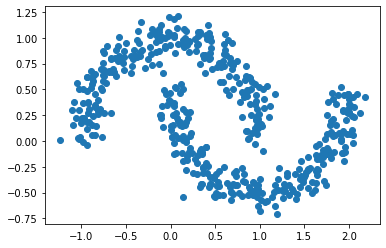

In [31]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd

X, _ = make_moons(n_samples=500, noise=0.1)
plt.scatter(X[:,0], X[:,1])
plt.show()

Кластеризуйте это с помощью своей версии DBSCAN:

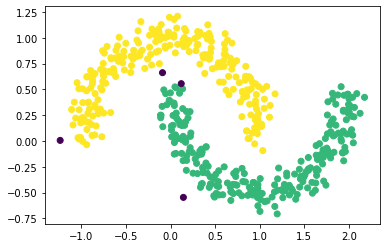

In [32]:
# your code here
clusters = dbscan(eps=0.2, min_samples=20).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Референс:

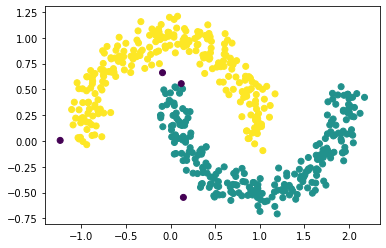

In [33]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=0.2, min_samples=20).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Получите 1 балл за ещё один интересный пример кластеризации (в качестве референса используйте предоставленное изображение. Нужно несколько интересных соседствующих форм):

In [149]:
points = []
s = list(map(float, input().split()))
for i in range(0, len(s), 3):
    points.append([s[i],s[i+1]])


11.25	5.05	1 10.95	4.7	1 9.85	5.8	1 9.8	5.75	1 9.15	6.8	1 8.65	6.6	1 8.4	7.5	1 7.9	7.75	1 6.95	8.7	1 7.25	9.75	1 7.3	10.25	1 5.9	10.7	1 5.85	11.8	1 6.45	12.05	1 5.7	12.95	1 5.35	13.45	1 5.4	14.65	1 4.7	14.85	1 5.4	15.4	1 5.1	16.25	1 5.75	16.7	1 4.85	17.65	1 5	18	1 6.05	18	1 5.7	19.45	1 5.3	19.55	1 5.85	21.25	1 6.1	21.35	1 6.55	22.15	1 5.9	22.8	1 7.15	23.7	1 6.75	24.25	1 7.95	24.65	1 7.75	25.3	1 8.8	26.05	1 8.85	26.95	1 9.35	27.45	1 9.95	27.1	1 11.25	28.2	1 10.7	28.55	1 11.95	29.45	1 11.95	28.65	1 13.1	30.05	1 13.4	29.3	1 14.7	30.2	1 14.7	30.6	1 16.1	30.4	1 16.1	31.05	1 17.55	30.8	1 17.65	31.75	1 18.55	31.6	1 18.85	30.6	1 19.85	30.9	1 20.1	31.3	1 21.5	31.35	1 20.85	30.4	1 22.95	30.05	1 23.4	30.3	1 24.2	29.9	1 24.75	30	1 25.55	29.3	1 25.55	28.45	1 26.7	28.3	1 26.85	28.75	1 27.6	27.15	1 28.25	27.4	1 29.05	27	1 29.05	26.2	1 29.45	25.55	1 30.05	25.55	1 30.3	23.3	1 30.6	23.95	1 30.9	22.75	1 31	22.3	1 30.65	21.3	1 31.3	20.8	1 31.85	21.2	1 31.45	19.3	1 32.7	19.3	1 31.9	17.9	1 33.05	18.05	1 32.

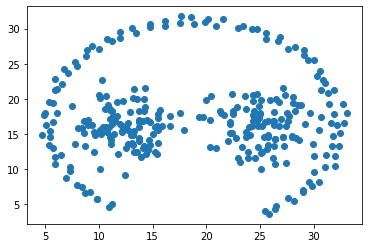

In [154]:
plt.scatter(np.array(points).T[0], np.array(points).T[1])
plt.show()

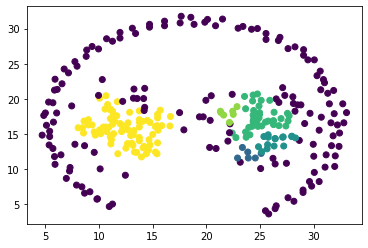

In [203]:
clusters = dbscan(eps=1.3, min_samples=6).fit_predict(np.array(points))

plt.scatter(np.array(points).T[0], np.array(points).T[1], c=clusters)
plt.show() #результат совпал с библиотечным  DBSCAN

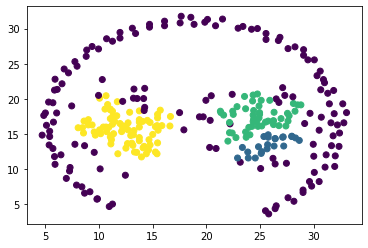

In [202]:
clusters = DBSCAN(eps=1.3, min_samples=6).fit_predict(np.array(points))

plt.scatter(np.array(points).T[0], np.array(points).T[1], c=clusters)
plt.show()

Получите ещё 1 балл, если время работы вашего алгоритма больше референсного не более чем в 100 раз с учётом погрешности 3% от вашего времени:

In [115]:
%%time
%%capture
clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

Wall time: 16 ms


In [116]:
%%time
%%capture
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

Wall time: 6.38 s
